# GeoCluster 1st hierarchy

Load required libraries and initiate basic objects.

In [1]:
# External libraries.
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
# Internal libraries.
from src.utils.data import loadData
from src import visualization as vis

Loading data...
Data loaded.
[100.         290.           1.           0.35545887]


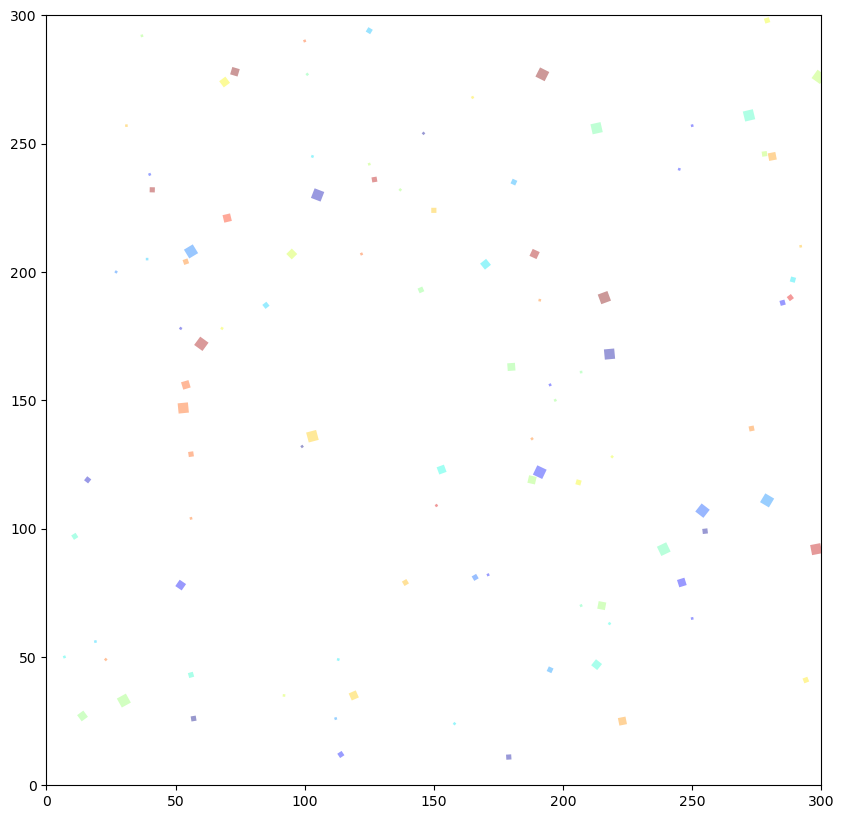

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Load data.
squares, _ = loadData(100)
print(squares[0])
vis.plot_data(squares, limits=[0, 300, 0, 300])

## Training Teacher

In [3]:
from src.models import LVGEBM
from src.train import trainTeacher

model = LVGEBM(4, 2, 400).to(device)
learning_rate = 1e-2
results = trainTeacher(model,
                       optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate),
                       epochs=200,
                       times=10,
                       device=device,
                       train_data=torch.from_numpy(squares).float().to(device),
                       alpha=5,
                       beta=10)

# Save results to .npy format.
np.save("models/squares/100/teacher_config.npy", results)
print("Saved teacher config to models/squares/100/teacher_config.npy")

Training Teacher Model
Epoch: 20/200..  Training loss: 8705.75391..  Reg Proj: 50.39276..  Reg Latent: 0.28040..  Memory: 8450.98633..  Cost: 8705.75391.. 
Epoch: 40/200..  Training loss: 12816.84863..  Reg Proj: 0.00000..  Reg Latent: 0.65914..  Memory: 12810.25684..  Cost: 12816.84863.. 
Epoch: 60/200..  Training loss: 7799.84814..  Reg Proj: 0.00000..  Reg Latent: 0.92455..  Memory: 7790.60254..  Cost: 7799.84814.. 
Epoch: 80/200..  Training loss: 8794.34961..  Reg Proj: 0.00000..  Reg Latent: 0.31636..  Memory: 8791.18652..  Cost: 8794.34961.. 
Epoch: 100/200..  Training loss: 7623.38867..  Reg Proj: 0.00000..  Reg Latent: 0.08415..  Memory: 7622.54736..  Cost: 7623.38867.. 
Epoch: 120/200..  Training loss: 7565.09131..  Reg Proj: 0.00000..  Reg Latent: 1.05076..  Memory: 7554.58350..  Cost: 7565.09131.. 
Epoch: 140/200..  Training loss: 7797.43848..  Reg Proj: 0.00000..  Reg Latent: 0.26630..  Memory: 7794.77539..  Cost: 7797.43848.. 
Epoch: 160/200..  Training loss: 8246.13184.. 

In [4]:
# Load  model from configuration, i.e. a dictionary in .npy format (No need to train each time).
results = np.load('./models/squares/100/teacher_config.npy', allow_pickle=True).item()
print("Loaded teacher config from models/squares/100/teacher_config.npy")

Load and print some important variables.

In [5]:
model = results["best_model"]
best_epoch = results["best_epoch"]
best_outputs = results["best_outputs"]
print("best epoch: ", best_epoch)
print("best outputs: ", best_outputs)
# print("costs: ", results["cost_array"])

best epoch:  106
best outputs:  tensor([[ 71.3150, 110.8751],
        [106.7818, 287.2889],
        [225.8502, 196.6441],
        [185.8335, 119.9903]], requires_grad=True)


### Plot results

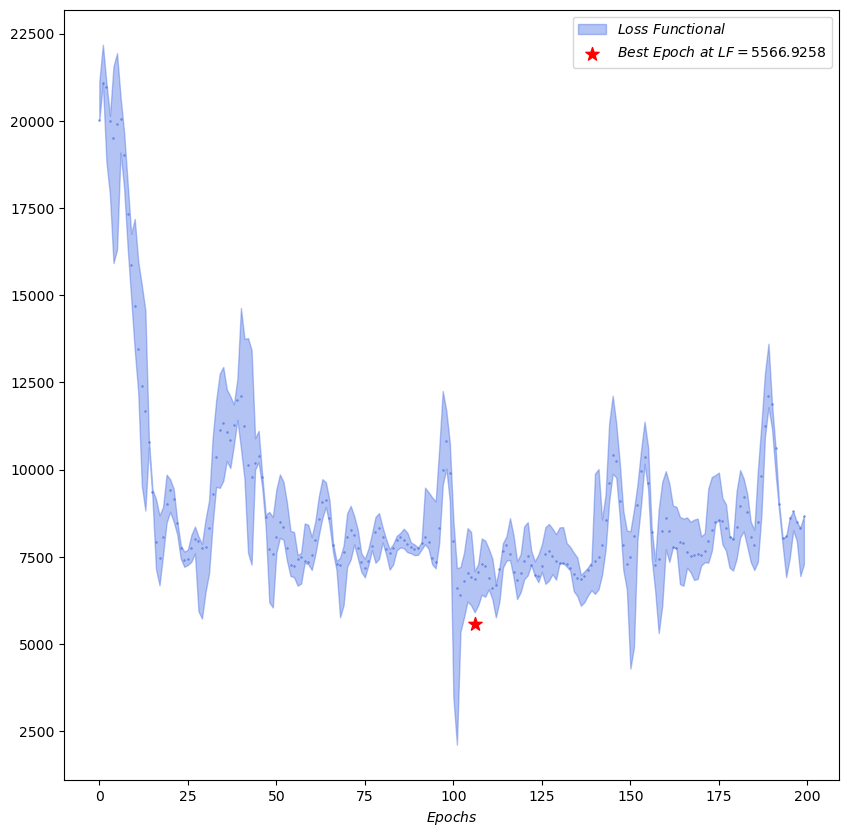

In [6]:
# Plot the Amplitude demodulation of the signal (costs array).
from src.utils.plot_tools import plot_AM_dem, AM_dem

signal = results["cost_array"]
upper_signal, lower_signal, filtered_signal = AM_dem(signal, fc=0.4*len(signal), fs=2*len(signal))
plot_AM_dem(upper_signal, lower_signal, filtered_signal, signal, best_epoch)

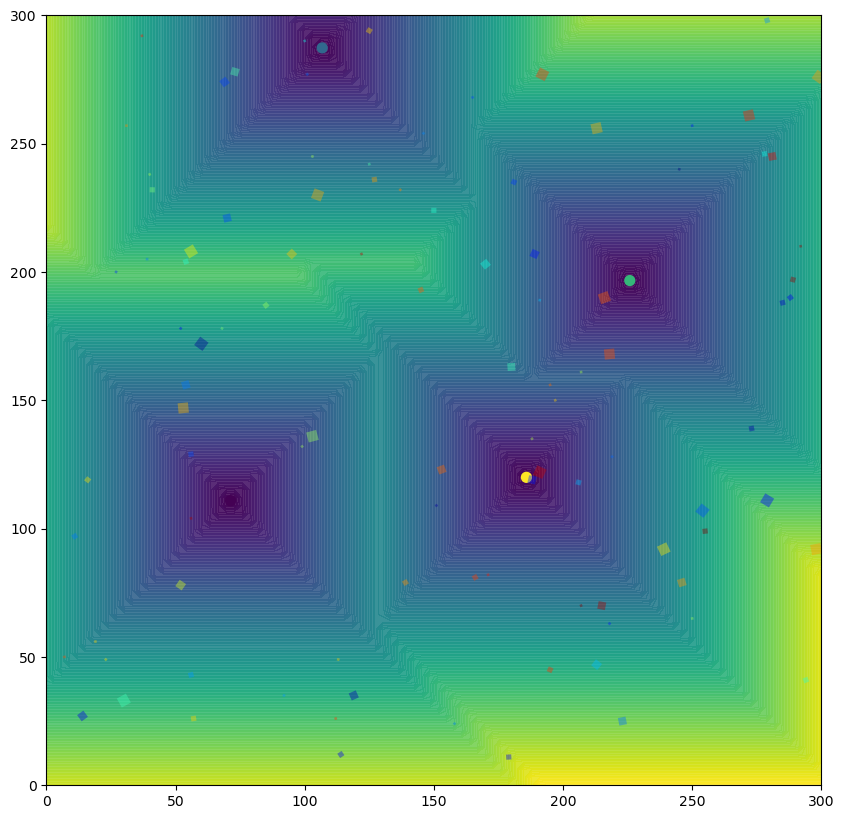

In [7]:
# Plot the best model with the best outputs.
from src.utils import plot_tools as pt
manifold = pt.createManifold(model, best_outputs.cpu())
pt.plotManifold(squares, manifold, best_outputs.cpu(), [0, 300], [0, 300])

## Uncertainty Area

Predicting...


/home/getekid/Sites/athenarc/GeoCluster/src/utils/functions.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  E = Linf_array(torch.tensor(n_points), torch.tensor(outputs))


Processing...
flag is 5155
m is 4846
i is 10000
Points sampled:  4846


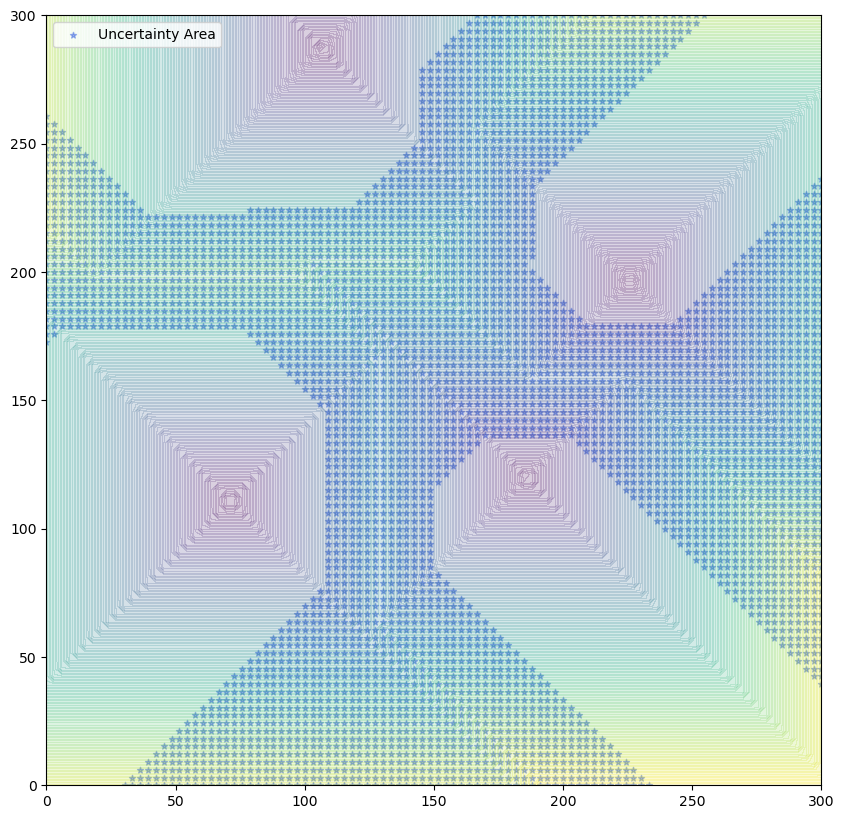

In [8]:
from src.utils.functions import getUncertaintyArea

sensitivity = 0.15
print('Predicting...')
m_points = getUncertaintyArea(best_outputs.cpu().detach().numpy(),
                              N=100,
                              M=10000-1,
                              epsilon=sensitivity,
                              x_area=[0,300],
                              y_area=[0,300],
                              model=model)
print('Points sampled: ', len(m_points))

# Plot the m points that are in the uncertainty area.
m_points = np.array(m_points)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(m_points[:, 0], m_points[:, 1], s=20, c='royalblue', alpha=0.5, marker='*', label='Uncertainty Area')
ax.contourf(manifold[:, :, 0], manifold[:, :, 1], manifold[:, :, -2], levels=200, cmap='viridis', alpha=0.2)
plt.legend()

## Labeling

In [9]:
from src.utils.functions import getE

qp = np.random.permutation(m_points)
qp = torch.tensor(qp)
# TODO: Pass squares to getE as an argument.
F, z, F_sq, z_sq = getE(model, best_outputs.cpu(), qp)

# Initialize the pseudo clusters.
# Append squares that their z_sq is i for each centroid.
pseudo_clusters = [squares[z_sq == i] for i in range(model.n_centroids)]

/home/getekid/Sites/athenarc/GeoCluster/src/utils/functions.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  qp = torch.tensor(qp)
/home/getekid/Sites/athenarc/GeoCluster/src/utils/functions.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs)


Loading data...
Data loaded.


### Create Labels

In [10]:
from src.utils.functions import NearestNeighbour

outputs_shape = (qp.shape[0], model.n_centroids)
F_ps = torch.zeros(outputs_shape)
z_ps = torch.zeros(outputs_shape)
for i in range(outputs_shape[0]):
    if i % 1000 == 0:
        print(f"Labeled {i}/{outputs_shape[0]} points.")
    for j in range(outputs_shape[1]):
        qpoint = qp[i].cpu().detach().numpy()
        F_ps[i,j], z_ps[i,j] = torch.tensor(NearestNeighbour(qpoint, pseudo_clusters[j]))
print(f"Labeled all {outputs_shape[0]}/{outputs_shape[0]} points.")
        

Labeled 0/4846 points.
Labeled 1000/4846 points.
Labeled 2000/4846 points.
Labeled 3000/4846 points.
Labeled 4000/4846 points.
Labeled all 4846/4846 points.


### Plot labels

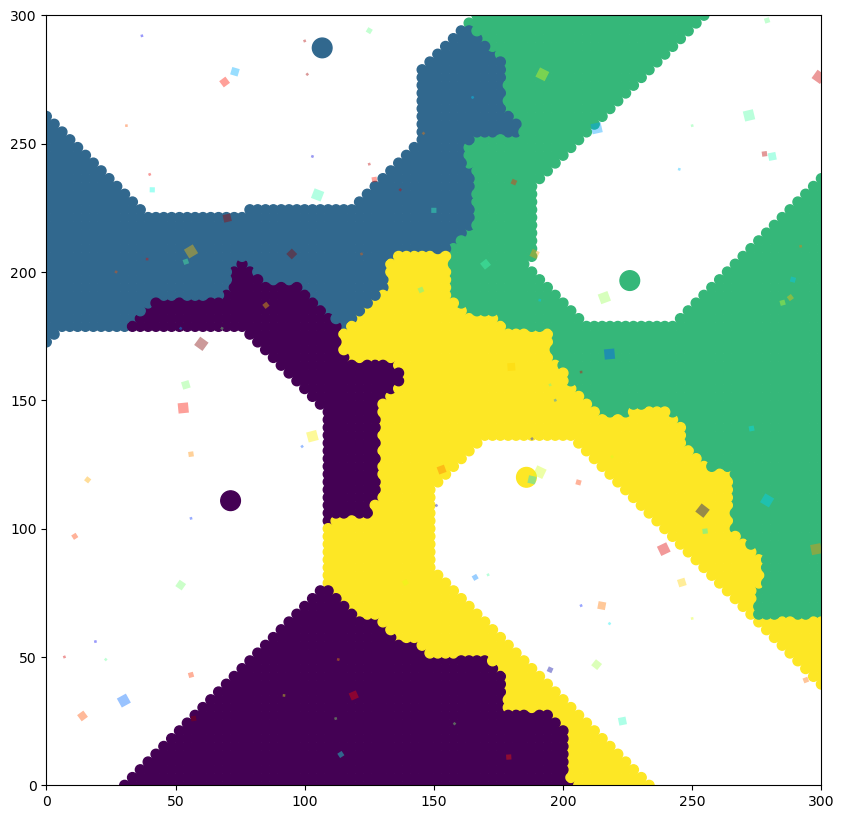

In [11]:
# plot qp
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
# labels are z
labels =  z
plt_qp = qp.cpu().detach().numpy()
new_labels = F_ps.min(1)[1].cpu().detach().numpy()
ax.scatter(plt_qp[:, 0], plt_qp[:, 1], c=new_labels, s=50)
# plot best_outputs
plt_bo = best_outputs.cpu().detach().numpy()
plt_bo = plt_bo
c = np.linspace(0, best_outputs.shape[0], best_outputs.shape[0])
ax.scatter(plt_bo[:, 0], plt_bo[:, 1], c=c, s=200)
z_labels = z
pt.plot_data_on_manifold(fig, ax, squares, size=10, limits=[0, 300, 0, 300])
# plot_data(fig,ax,sq, size=10, limits=[0,300,0,300])

## Training Student

In [12]:
from src.models import Voronoi
vor = Voronoi(4, 2, 2).to(device) # initialize the voronoi network
loss = nn.L1Loss() # initialize the loss function
qp = torch.tensor(qp) # send qp to device
optimizer = torch.optim.Adam(vor.parameters(), lr=1e-3) # initialize the optimizer
epochs = 30000 # number of epochs
squares, _ = loadData(100) # load the squares
"""
pseudo_clusters = [] # initialize the pseudo clusters
for i in range(n_centroids):
    # append squares that their z_sq is i
    pseudo_clusters.append(squares[z_sq==i])
"""
F_l = []
z_l = []
cost_l = []
cost_ll = []
qp = torch.tensor(qp).to(device)
outputs = torch.zeros(qp.shape[0], model.n_centroids)

ce = nn.CrossEntropyLoss()
acc_l = []
l_ce = []
es = []
best_vor_cost = torch.inf
best_vor_mode = None
for epoch in range(epochs):
    qp = torch.tensor(qp, dtype=torch.float32).to(device)
    # get outputs
    outputs = vor(qp)
    # pass outputs through a hard arg max
    F, z = outputs.min(1)
    F_ps_m, z_ps_m = F_ps.min(1)
    # send to device
    F_ps_m = F_ps_m.to(device)
    z_ps_m = z_ps_m.to(device)
    #make values of z_ps_m to be round to nearest integer
    r_z = torch.round(z_ps_m)
    # get loss
    alpha = 100
    beta = 1000
    z = z.float()
    z_ = outputs
    # make z_ float
    z_ = z_.float()
    z_cost = ce(z_, z_ps_m)
    F_cost = loss(F, F_ps_m)
    # get z_cost where we only penalize the wrong z and not its distance
    #z_cost = penalty(z, r_z)
    #F_l.append(F_cost.item())
    z_l.append(z_cost)
    #cost = alpha*F_cost + beta*z_cost
    cost = 100 * z_cost 
    cost_l.append(cost.item())
    # backward
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    if cost < best_vor_cost:
        best_vor_cost = cost
        best_vor_model = vor
    if epoch % 2000 == 0:
        # lets check acc
        acc = 0
        for i in range(qp.shape[0]):
            F_e, z_e = outputs[i].max(0)
            if z_e == z_ps_m[i]:
                acc += 1
        acc_l.append(acc / qp.shape[0])
        es.append(epoch)
        cost_ll.append(cost.item())

        if epoch % 200==0:
            print("Acc: ", acc / qp.shape[0])
            print("Epoch: ", epoch, "Cost: ", cost.item())

/tmp/ipykernel_11568/2917020731.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  qp = torch.tensor(qp) # send qp to device
/tmp/ipykernel_11568/2917020731.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  qp = torch.tensor(qp).to(device)
/tmp/ipykernel_11568/2917020731.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  qp = torch.tensor(qp, dtype=torch.float32).to(device)


Loading data...
Data loaded.
Acc:  0.2505158893933141
Epoch:  0 Cost:  1682.494873046875
Acc:  0.8786628146925299
Epoch:  2000 Cost:  28.622098922729492
Acc:  0.9434585224927775
Epoch:  4000 Cost:  17.168729782104492


KeyboardInterrupt: 

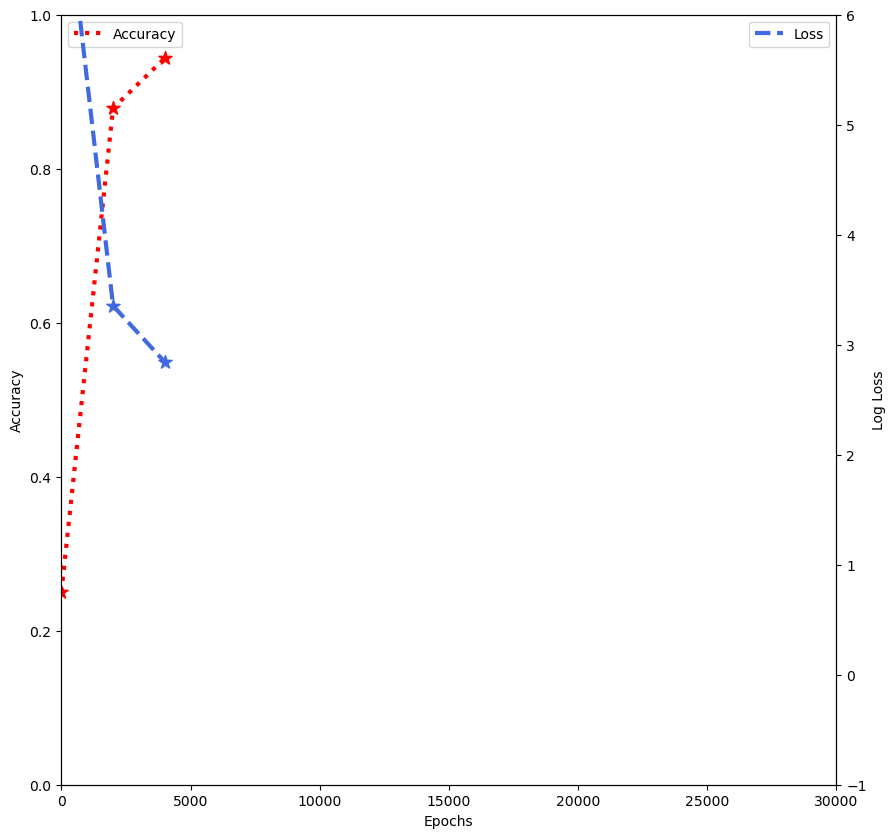

In [13]:
# Plot Accuracy and Loss
cost_ll_log = np.log(cost_ll)
    
fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.plot(es, acc_l, c='r', label='Accuracy', linestyle='dotted', linewidth=3)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')
ax1.set_ylim([0, 1])
# create another twin axis
ax2 = ax1.twinx()
ax2.plot(es, cost_ll_log, c='royalblue', label='Loss', linestyle='dashed', linewidth=3)
ax2.set_ylabel('Log Loss')
ax2.legend(loc='upper right')
ax2.set_ylim([-1, 6])
# set x_lim in both
ax1.set_xlim([0, epochs])
ax2.set_xlim([0, epochs])
# add stars to the plot points
ax1.scatter(es, acc_l, c='r', s=100, marker='*')
ax2.scatter(es, cost_ll_log, c='royalblue', s=100, marker='*')

In [14]:
# save voronoi model
def save_Student_config(model):
    # save model
    torch.save(model.state_dict(), "models/squares/100/student_config.pt")
    print("saved student config to results/student_config.pt")
save_Student_config(best_vor_model)

saved student config to results/student_config.pt


## Inferencing

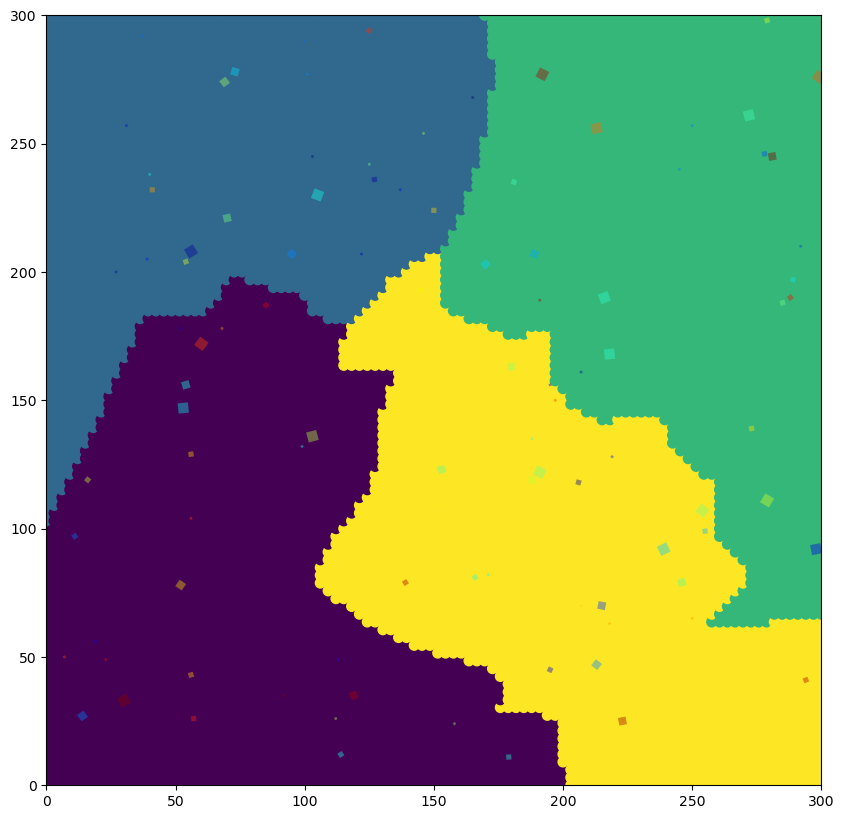

In [15]:
# ok lets infer
infer_points = torch.zeros(10000, 2) # initialize the infer points
x_lim = [0, 300] # x limits
y_lim = [0, 300] # y limits
for i, x in enumerate(np.linspace(x_lim[0], x_lim[1], 100)): # sample 100 points in x_lim
    for j, y in enumerate(np.linspace(y_lim[0], y_lim[1], 100)): # sample 100 points in y_lim
        infer_points[i * 100 + j] = torch.Tensor([x, y]) # append the point to infer_points

infer_points = infer_points.to(device) # send infer_points to device
classes = best_vor_model(infer_points) # get the classes of infer_points
infer_points = infer_points.cpu().detach().numpy() # send infer_points to cpu
classes = classes.max(1)[-1].cpu().detach().numpy() # send classes to cpu
# plot classes
fig = plt.figure(figsize=(10, 10)) # initialize the figure
ax = fig.add_subplot(111) # add subplot
#manifold_plot = manifold_plot.cpu().detach().numpy()
ax.scatter(infer_points[:, 0], infer_points[:, 1], c=classes, s=50) # plot infer_points
#ax.contourf(manifold1[:,:,0], manifold1[:,:,1], classes, levels=level, cmap='viridis', alpha=0.9)
# plot scatter of output = model(model.z)
pt.plot_data_on_manifold(fig, ax, squares, size=10, limits=[0, 300, 0, 300]) # plot sq

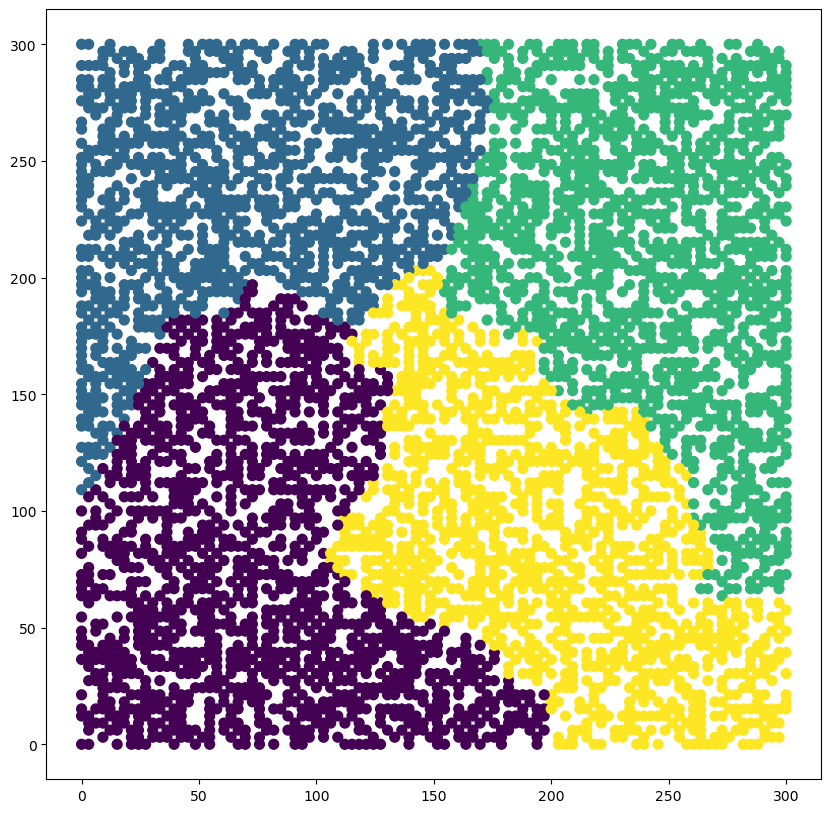

In [16]:
# take 10000 points randomly in [0,300]x[0,300]
random_p = torch.zeros(10000, 2)
x_lim = [0, 300]
y_lim = [0, 300]
for i, x in enumerate(np.linspace(x_lim[0], x_lim[1], 100)):
    for j, y in enumerate(np.linspace(y_lim[0], y_lim[1], 100)):
        random_p[i * 100 + j] = torch.Tensor([x, y])

infer_points = random_p.to(device)
# take 5000 randomly of those
num = 5000
infer_points = random_p[torch.randperm(random_p.shape[0])][:5000]
# =
infer_points = infer_points.to(device)
classes = best_vor_model(infer_points)
z = classes.max(1)[-1].cpu().detach().numpy()
infer_points = infer_points.cpu().detach().numpy()
# plot infer_points
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(infer_points[:, 0], infer_points[:, 1], c=z, s=50)

In [17]:
# randomly infered points
#infer_points = torch.randn(10000, 2)
# they must be in [0,300]x[0,300]
#infer_points = infer_points*150 + 150
n = 0 # counter
outputs = torch.zeros(infer_points.shape[0], model.n_centroids) # initialize outputs
F_ps_infer = torch.zeros(outputs.shape[0], outputs.shape[1]) # initialize F_ps
z_ps_infer = torch.zeros(outputs.shape[0], outputs.shape[1]) # initialize z_ps
for i in range(outputs.shape[0]): # for each infer point
    for j in range(outputs.shape[1]): # for each pseudo cluster
        qpoint = infer_points[i] # get the infer point
        F_ps_infer[i, j], z_ps_infer[i, j] = torch.tensor(NearestNeighbour(qpoint, pseudo_clusters[j])) # get the Linf distance between the infer point and the pseudo cluster
    if n % 1000 == 0: # print every 1000 points
        print(n) # print n
    n += 1 # increment n
z_i = F_ps_infer.min(1)[1].cpu().detach().numpy() # get the z_i

0
1000
2000
3000
4000


In [18]:
# Get Accuracy
# get all the number of times z == z_i
times = [z == z_i]
print(np.sum(times) / z.shape[0])
print("Number of false predictions: ", z.shape[0] - np.sum(times))

0.963
Number of false predictions:  185


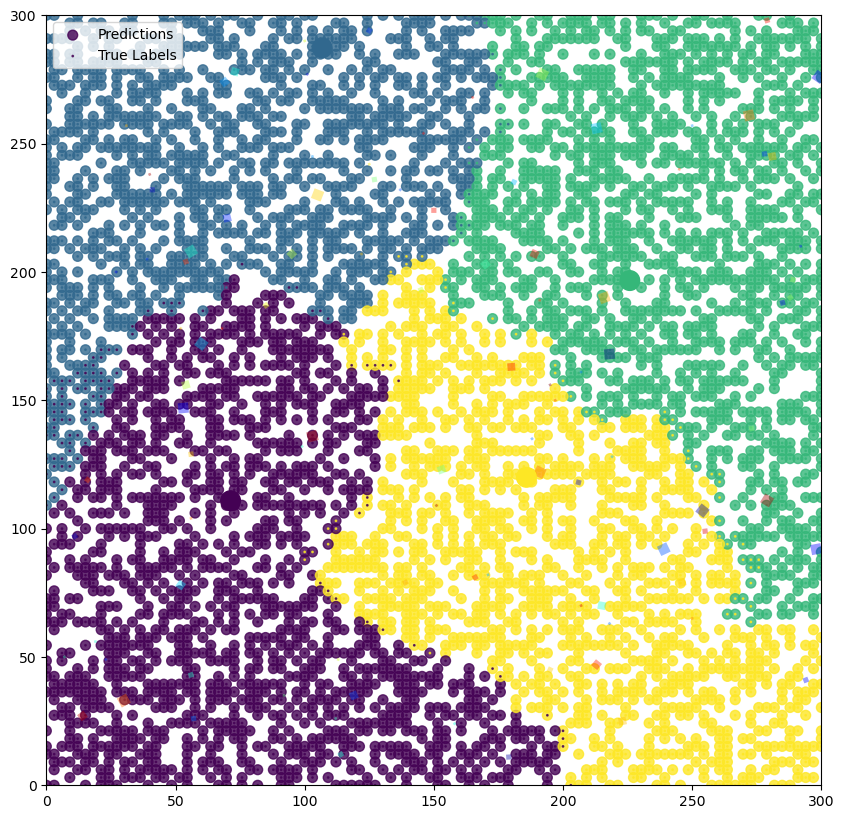

In [19]:
# plot points
fig = plt.figure(figsize=(10, 10)) # initialize the figure
ax = fig.add_subplot(111) # add subplot
infer_points_plt = infer_points # infer_points
#z = z
classes_ = z # z
ax.scatter(infer_points_plt[:, 0], infer_points_plt[:, 1], c=z, s=50, label='Predictions', alpha=0.8) # plot infer_points
# plot z_i labels
# color
classes_ = z_i # z_i
ax.scatter(infer_points_plt[:, 0], infer_points_plt[:, 1], c=classes_, s=1, label='True Labels', alpha=0.8) # plot infer_points
ax.set_xlim([0, 300])
ax.set_ylim([0, 300])
# plot legend
plt.legend(scatterpoints=1, loc='upper left', fontsize=10)
# also vis data
pt.plot_data_on_manifold(fig, ax, squares, size=10, limits=[0, 300, 0, 300])
# plot best_outputs
plt_bo = best_outputs.cpu().detach().numpy()
plt_bo = plt_bo
c = np.linspace(0, best_outputs.shape[0], best_outputs.shape[0])
ax.scatter(plt_bo[:, 0], plt_bo[:, 1], c=c, s=200)